In [37]:
#Downloads market data from Yahoo! Finance's API
#https://pypi.org/project/yfinance/
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd


In [38]:
#creates instance of ticker class for s&p500
stock = yf.Ticker("^GSPC")

In [39]:
#get max historical market data for sp500
stock = stock.history(period="max")

In [40]:
stock.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-05-06 00:00:00-04:00', '2024-05-07 00:00:00-04:00',
               '2024-05-08 00:00:00-04:00', '2024-05-09 00:00:00-04:00',
               '2024-05-10 00:00:00-04:00', '2024-05-13 00:00:00-04:00',
               '2024-05-14 00:00:00-04:00', '2024-05-15 00:00:00-04:00',
               '2024-05-16 00:00:00-04:00', '2024-05-17 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24211, freq=None)

<Axes: xlabel='Date'>

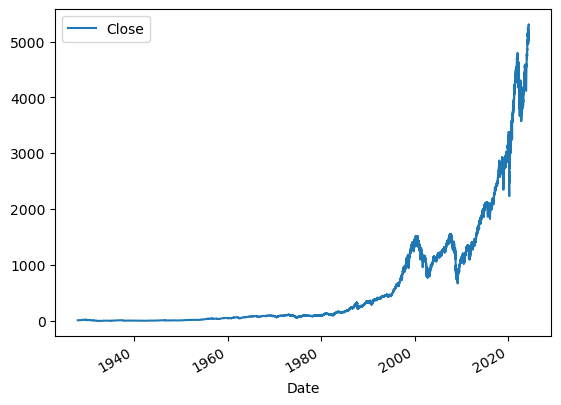

In [41]:
stock.plot.line(y="Close",use_index=True)

In [42]:
#creates tmr column and makes info in it equal to price of next day's close
stock["Tomorrow"] = stock["Close"].shift(-1)

In [43]:
#creates target column, assigns it to boolean of tmr > close, converts that boolean into an int
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

In [44]:
#debating commenting out
del stock["Dividends"]
del stock["Stock Splits"]

In [45]:
#creates more up to date copy of stock market data if stock is old
stock = stock.loc["1990-01-01":].copy()

#delete later... added to match date of video source
#stock = stock.loc[:"2022-05-18"].copy()

In [46]:
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-05-13 00:00:00-04:00,5233.080078,5237.259766,5211.160156,5221.419922,4255710000,5246.680176,1
2024-05-14 00:00:00-04:00,5221.100098,5250.370117,5217.979980,5246.680176,4763580000,5308.149902,1
2024-05-15 00:00:00-04:00,5263.259766,5311.759766,5263.259766,5308.149902,4360810000,5297.100098,0


In [47]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [48]:
#used to measure how accurate predictions are

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds, zero_division=0)

0.0

<Axes: xlabel='Date'>

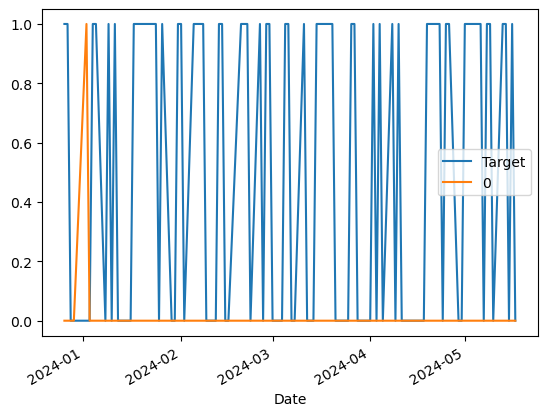

In [49]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [50]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds,index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [51]:
#each market year is around 250 days for us 9am-4pm market
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    print("Data length: ", len(data))
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    print("backtesting done!")
    return pd.concat(all_predictions)


In [52]:
predictions = backtest(stock, model, predictors)

8661
backtesting done!


In [53]:
predictions["Predictions"].value_counts()

Predictions
0    3565
1    2596
Name: count, dtype: int64

In [54]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [55]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534653
0    0.465347
Name: count, dtype: float64

In [56]:
#rolling averages
#close price across 2 days, week, 3 months, year, 4 years
horizons = [2,5,60,250,1000]

new_predictors = []
for horizon in horizons:

    rolling_averages = stock.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]

    trend_column= f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [57]:
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-13 00:00:00-04:00,5233.080078,5237.259766,5211.160156,5221.419922,4255710000,5246.680176,1,0.999879,1.0,1.002825,3.0,1.017942,30.0,1.122690,139.0,1.254150,531.0
2024-05-14 00:00:00-04:00,5221.100098,5250.370117,5217.979980,5246.680176,4763580000,5308.149902,1,1.002413,1.0,1.005399,3.0,1.022066,31.0,1.127019,140.0,1.259524,531.0
2024-05-15 00:00:00-04:00,5263.259766,5311.759766,5263.259766,5308.149902,4360810000,5297.100098,0,1.005824,2.0,1.012503,4.0,1.032924,32.0,1.139098,140.0,1.273572,531.0


In [58]:
#drops rows with Na values
stock = stock.dropna()

In [59]:
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 00:00:00-04:00,5225.490234,5239.660156,5209.680176,5222.680176,3617900000,5221.419922,0,1.000824,2.0,1.004637,4.0,1.018822,31.0,1.124010,140.0,1.255138,531.0
2024-05-13 00:00:00-04:00,5233.080078,5237.259766,5211.160156,5221.419922,4255710000,5246.680176,1,0.999879,1.0,1.002825,3.0,1.017942,30.0,1.122690,139.0,1.254150,531.0
2024-05-14 00:00:00-04:00,5221.100098,5250.370117,5217.979980,5246.680176,4763580000,5308.149902,1,1.002413,1.0,1.005399,3.0,1.022066,31.0,1.127019,140.0,1.259524,531.0


In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [61]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    #returns 1 when probability is above .5 by default but we prefer .6 for greater certainty
    #reduced trading days number but increases quality 
    # so far threshold of .628 yielded best precision 0.6064690026954178

    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds,index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


In [62]:
predictions = backtest(stock, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

7660
backtesting done!


0.5736526946107784

In [63]:
predictions["Predictions"].value_counts()

Predictions
0.0    4325
1.0     835
Name: count, dtype: int64

In [64]:
predictions["Predictions"]

Date
2003-11-14 00:00:00-05:00    0.0
2003-11-17 00:00:00-05:00    1.0
2003-11-18 00:00:00-05:00    1.0
2003-11-19 00:00:00-05:00    0.0
2003-11-20 00:00:00-05:00    1.0
                            ... 
2024-05-10 00:00:00-04:00    0.0
2024-05-13 00:00:00-04:00    0.0
2024-05-14 00:00:00-04:00    0.0
2024-05-15 00:00:00-04:00    0.0
2024-05-16 00:00:00-04:00    0.0
Name: Predictions, Length: 5160, dtype: float64

In [65]:
select_prod = predictions.loc[predictions["Target"] == 1.0]
select_prod = select_prod.loc[select_prod["Predictions"] == 1.0] 
display(select_prod)
print (select_prod.describe())

,Target,Predictions
Date,,
2003-11-18 00:00:00-05:00,1,1.0
2003-11-20 00:00:00-05:00,1,1.0
2003-12-10 00:00:00-05:00,1,1.0
2004-02-24 00:00:00-05:00,1,1.0
2004-03-11 00:00:00-05:00,1,1.0
...,...,...
2023-12-06 00:00:00-05:00,1,1.0
2024-01-05 00:00:00-05:00,1,1.0
2024-01-17 00:00:00-05:00,1,1.0


       Target  Predictions
count   479.0        479.0
mean      1.0          1.0
std       0.0          0.0
min       1.0          1.0
25%       1.0          1.0
50%       1.0          1.0
75%       1.0          1.0
max       1.0          1.0


In [67]:
stock.loc[:, ("Predictions")] = predictions['Target']
#stock["Predictions"] = predictions["Predictions"]
#.loc[:, ('Predictions')]
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,Predictions
Date,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0,NaN
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0,NaN
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0,NaN
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0,NaN
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 00:00:00-04:00,5225.490234,5239.660156,5209.680176,5222.680176,3617900000,5221.419922,0,1.000824,2.0,1.004637,4.0,1.018822,31.0,1.124010,140.0,1.255138,531.0,0.0
2024-05-13 00:00:00-04:00,5233.080078,5237.259766,5211.160156,5221.419922,4255710000,5246.680176,1,0.999879,1.0,1.002825,3.0,1.017942,30.0,1.122690,139.0,1.254150,531.0,1.0
2024-05-14 00:00:00-04:00,5221.100098,5250.370117,5217.979980,5246.680176,4763580000,5308.149902,1,1.002413,1.0,1.005399,3.0,1.022066,31.0,1.127019,140.0,1.259524,531.0,1.0
